In [1]:
# cargamos las librerias a utilizar

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [2]:
# esta celda sirve para dar permiso al accedo de tus archivos del gdrive

link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vS3Zbvu738Xi67ARfeqxG-Z46zXqTSK-sZUyEi9vRnFkQY7YJfNRdRt9iT4iXhYPg/pub?gid=1698849688&single=true&output=csv'

In [3]:
data = pd.read_csv(link)
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
# seteando la columna Month como índice

df = data.set_index('Month')
df.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [5]:
# selecciono la columna de interés #Passengers y la redimensionamos a vector columna (-1,1)

dataset = data.iloc[:,1].values.reshape(-1,1)
len(dataset)

144

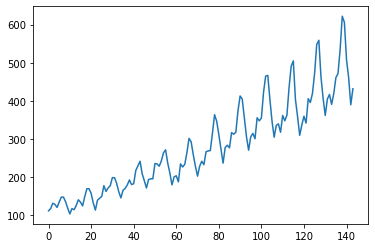

In [6]:
plt.plot(dataset)

MinMaxScaler

In [7]:
# escalando datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range = (0,1))
dataset = scaler.fit_transform(dataset)

Creando el conjunto de train y test

In [8]:
# train_test_split

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

Crear la función para transformar la serie a matriz

In [9]:
def to_sequences(dataset, seq_size = 1):
    x=[]
    y=[]
    
    for i in range(len(dataset) - seq_size-1):
        window = dataset[i:(i+seq_size),0]
        x.append(window)
        y.append(dataset[i+seq_size,0])
    
    return np.array(x),np.array(y)

Convertimos serie a array

In [10]:
# seq_size = timestep : es el número de columnas X

seq_size = 12

trainX, trainY = to_sequences(train,seq_size)
testX, testY = to_sequences(test,seq_size)

In [11]:
print(trainX.shape)
print(testX.shape)

(102, 12)
(16, 12)


Transformando las tablas 2D a tensores 3D

In [12]:
# redimensionando los inputs para la CNN

# reshape from [samples, timesteps] into [samples, timesteps, features]

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

print(trainX.shape, testX.shape)

(102, 12, 1) (16, 12, 1)


Creación de la CNN

In [13]:
# Creando la red neuronal
# input_shape (columnas, características)

model = Sequential()
model.add(Conv1D(64, 2, activation='relu', input_shape=(seq_size, 1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Entrenar la CNN

In [14]:
EPOCHS = 100

history = model.fit(trainX,trainY,epochs = EPOCHS,validation_data = (testX,testY), verbose = 1)

Epoch 1/100
4/4 [==============================] - 0s 30ms/step - loss: 0.0863 - val_loss: 0.1839
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0240 - val_loss: 0.0529
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0087 - val_loss: 0.0271
Epoch 4/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0317
Epoch 5/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0106 - val_loss: 0.0271
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0069 - val_loss: 0.0295
Epoch 7/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0066 - val_loss: 0.0372
Epoch 8/100
4/4 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0372
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0315
Epoch 10/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0258
Epoch 11/100
4/4 [==========

Text(0.5, 1.0, 'ECM vs. epochs')

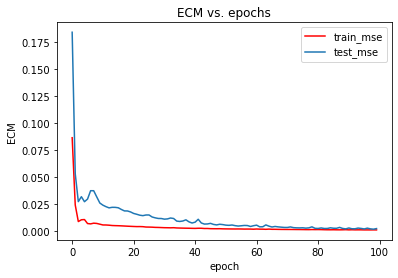

In [15]:
# ECM error cuadrático medio

plt.plot(history.history['loss'],color = 'r',label = 'train_mse')
plt.plot(history.history['val_loss'],label = 'test_mse')
plt.xlabel('epoch')
plt.ylabel('ECM')
plt.legend(loc = 'best')
plt.title('ECM vs. epochs')

In [16]:
# predicciones

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

In [17]:
# preparando data para el plot

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size,:] = trainPredict

# shift test predictions 
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1:] = testPredict

<function matplotlib.pyplot.show(close=None, block=None)>

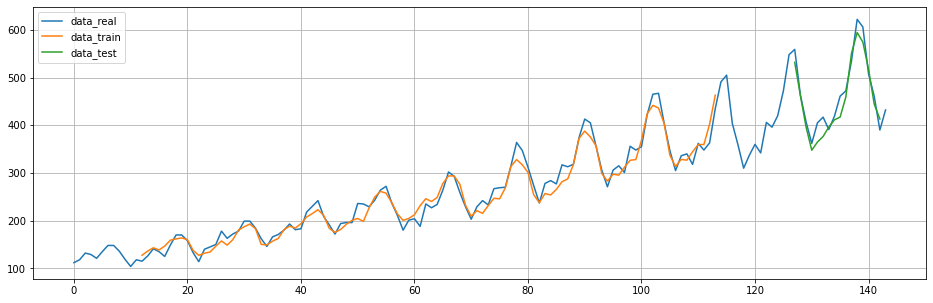

In [18]:
# ploteando predicciones

plt.figure(figsize = (16,5))

plt.plot(scaler.inverse_transform(dataset), label = 'data_real')
plt.plot(trainPredictPlot, label = 'data_train')
plt.plot(testPredictPlot, label = 'data_test')
plt.legend(loc = 'best')
plt.grid()
plt.show

Pronóstico

In [19]:
# data de test

testX.shape

(16, 12, 1)

In [20]:
# el último registro de la data de test

testX, testY = to_sequences(test,seq_size)
testX = testX[-1,:].reshape(-1,seq_size)
testX.shape

(1, 12)

In [21]:
# convierto a tensor 3D

x_test = testX.reshape((testX.shape[0], testX.shape[1],1))
x_test.shape

(1, 12, 1)

In [22]:
# con esto lleno la matriz para seguir calculando los puntos futuros
# mover la variable pron que indica el número de puntos a pronosticar

pron = 24

def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[1]-1):
        x_test[0][i][0] = x_test[0][i+1][0]
    x_test[0][x_test.shape[1]-1][0] = nuevoValor
    return x_test

results = []
for i in range(pron):
    parcial = model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test = agregarNuevoValor(x_test,parcial[0])

[[[0.4980695 ]
  [0.58108103]
  [0.6042471 ]
  [0.554054  ]
  [0.60810804]
  [0.6891892 ]
  [0.71042466]
  [0.8320464 ]
  [1.        ]
  [0.96911204]
  [0.7799227 ]
  [0.6891892 ]]]
[[[0.58108103]
  [0.6042471 ]
  [0.554054  ]
  [0.60810804]
  [0.6891892 ]
  [0.71042466]
  [0.8320464 ]
  [1.        ]
  [0.96911204]
  [0.7799227 ]
  [0.6891892 ]
  [0.59700805]]]
[[[0.6042471 ]
  [0.554054  ]
  [0.60810804]
  [0.6891892 ]
  [0.71042466]
  [0.8320464 ]
  [1.        ]
  [0.96911204]
  [0.7799227 ]
  [0.6891892 ]
  [0.59700805]
  [0.6247281 ]]]
[[[0.554054  ]
  [0.60810804]
  [0.6891892 ]
  [0.71042466]
  [0.8320464 ]
  [1.        ]
  [0.96911204]
  [0.7799227 ]
  [0.6891892 ]
  [0.59700805]
  [0.6247281 ]
  [0.6289017 ]]]
[[[0.60810804]
  [0.6891892 ]
  [0.71042466]
  [0.8320464 ]
  [1.        ]
  [0.96911204]
  [0.7799227 ]
  [0.6891892 ]
  [0.59700805]
  [0.6247281 ]
  [0.6289017 ]
  [0.60752225]]]
[[[0.6891892 ]
  [0.71042466]
  [0.8320464 ]
  [1.        ]
  [0.96911204]
  [0.7799227 ]


Volviendo al valor original

In [23]:
# valores inversos al escalado

adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[413.25017498],
       [427.60915293],
       [429.77109665],
       [418.69653055],
       [444.23863182],
       [466.49653736],
       [518.49924642],
       [603.45043218],
       [647.91282916],
       [632.60940952],
       [555.41682355],
       [489.57788467],
       [449.15050668],
       [450.21539256],
       [438.84260284],
       [439.55094183],
       [459.84635749],
       [498.11700968],
       [569.83359988],
       [633.53492471],
       [672.64813041],
       [660.48323727],
       [594.59952933],
       [522.41027059]])

In [24]:
# concatenar df

df.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [25]:
y_pred = pd.DataFrame(inverted)
len(y_pred)

24

<AxesSubplot:>

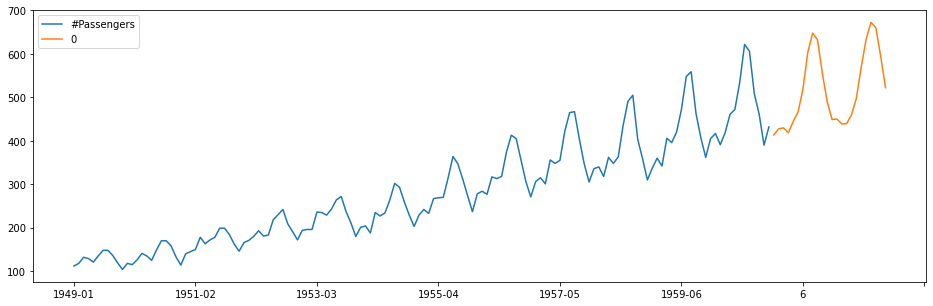

In [26]:
df2 = pd.concat([df,y_pred])
df2.plot(figsize=(16,5))

In [29]:
df2

,#Passengers,0
1949-01,112.0,NaN
1949-02,118.0,NaN
1949-03,132.0,NaN
1949-04,129.0,NaN
1949-05,121.0,NaN
...,...,...
19,NaN,633.534925
20,NaN,672.648130
21,NaN,660.483237
22,NaN,594.599529


In [30]:
df2.to_excel('datasalida1.xlsx')